In [1]:
import pandas as pd

In [2]:
import os
import numpy as np
import pydicom
import scipy.misc
import scipy

In [3]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [4]:
base_path = '/Users/lifesailor/Desktop/project/medical-image-synthesis-gan/data/train/'
contrast_path = 'CT(CE)/2.PG+30/'
original_path = 'CT/2.PG+30/'

In [5]:
files = os.listdir(base_path)
files.sort()
files = [file for file in files if '_' not in file and ' ' not in file]

In [6]:
original_total_path = [os.path.join(os.path.join(base_path, file), original_path) for file in files]
contrast_total_path = [os.path.join(os.path.join(base_path, file), contrast_path) for file in files]

# 1. Get File and Image

### 1. File

In [7]:
from tqdm import tqdm, tqdm_notebook, trange

In [8]:
def load_files(path):
    total_files = []
    
    # list
    path = tqdm_notebook(path)
    
    for base_path in path:    
        files = os.listdir(base_path)
        files.sort()
        
        # files
        folder_files = []
        for file in files:
            data = pydicom.dcmread(os.path.join(base_path, file))
            folder_files.append(data)
        total_files.append(folder_files)
        
    return total_files

In [9]:
original_total_files = load_files(original_total_path)
contrast_total_files = load_files(contrast_total_path)

### 1. 회사 종류

In [290]:
def get_manufaturer(file):
    file_info = file[0]
    file_info = str(file_info)
    manufacturer = file_info.split('Manufacturer')[1]
    manufacturer = manufacturer.split('\n')[0].split('LO:')[1].lower()
    return manufacturer

In [291]:
manufacturer = []

for file in original_total_files:
    manufacturer.append(get_manufaturer(file))

In [293]:
np.unique(np.array(manufacturer))

array([" 'ge medical systems'", " 'siemens'"], dtype='<U21')

In [296]:
'siemens' in manufacturer[0]

True

### 2. 모델 종류

In [282]:
def get_model(file):
    file_info = file[0]
    file_info = str(file_info)
    model = file_info.split('Manufacturer\'s Model Name')[1]
    model = model.split('\n')[0]
    return model

In [283]:
models = []

for file in original_total_files:
    models.append(get_model(file))

In [286]:
np.unique(np.array(models))

array(["           LO: 'GMS Discovery 750\\x00'",
       "           LO: 'GMS Discovery 750_CC'",
       "           LO: 'GMS Revolution_TC\\x00'",
       "           LO: 'SMS Definition AS+'",
       "           LO: 'SMS Definition'"], dtype='<U38')

In [284]:
pd.Series(models).value_counts()

           LO: 'SMS Definition AS+'       41
           LO: 'GMS Discovery 750\x00'    40
           LO: 'SMS Definition'           33
           LO: 'GMS Revolution_TC\x00'    28
           LO: 'GMS Discovery 750_CC'      4
dtype: int64

### 2. Image

In [52]:
def load_images(files):
    total_images = []
    
    files = tqdm_notebook(files)
    
    # list
    for file in files:
        sequence_image = []
        
        for sequence in file:
            sequence_image.append(sequence.pixel_array)
        total_images.append(sequence_image)

    return total_images

In [53]:
original_total_images = load_images(original_total_files)
contrast_total_images = load_images(contrast_total_files)

# 2. Imshow

- 하나의 sequence 대해서 비슷한지 확인하기

In [55]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [60]:
def f(files, sequence):
    fig = plt.figure(figsize=(15, 5))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(original_total_images[files][sequence], cmap='gray')

    fig.add_subplot(1, 3, 2)
    plt.imshow(original_total_images[files + 1][sequence], cmap='gray')

    fig.add_subplot(1, 3, 3)
    plt.imshow(original_total_images[files + 2][sequence], cmap='gray')

In [61]:
interactive_plot = interactive(f, files=range(0, len(files), 3), sequence=range(30))
interactive_plot

interactive(children=(Dropdown(description='files', options=(0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 3…

In [58]:
def f2(files, sequence):
    fig = plt.figure(figsize=(15, 5))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(contrast_total_images[files][sequence], cmap='gray')

    fig.add_subplot(1, 3, 2)
    plt.imshow(contrast_total_images[files + 1][sequence], cmap='gray')

    fig.add_subplot(1, 3, 3)
    plt.imshow(contrast_total_images[files + 2][sequence], cmap='gray')

In [59]:
interactive_plot = interactive(f2, files=range(0, len(files), 3), sequence=range(30))
interactive_plot

interactive(children=(Dropdown(description='files', options=(0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 3…

# 3. Plan

### 데이터 수집

1. 하나의 장비의 데이터를 많이 모을수록 좋습니다.
    - 적어도 같은 회사이어야 합니다.
    - 쉬운 문제부터 풀고 어려운 문제를 풉니다.
    - 하나의 장비에서 하는 것이 더 쉽습니다.

### 알고리즘에 사용할 데이터 관점

1. 회사
    - 문제는 데이터 양이 줄어든다
         1) 나누어서 실험하기 2) multi-task 등으로 해결해야 한다.
    - 둘 다 실험해야 합니다.
2. Sequence 
    - sequence를 구분해서 넣는다.
        1) 추가로 sequence 정보를 넣는다 2) 중요 sequence만 뽑는다

### 논의 사항

1. dicom 파일에 많은 정보가 들어가 있다.
    - 이것을 같이 쓸 수 있는 방법은 없는가.
    - 우선 이미지만 가지고 한다.

### 단계
  
1. Segmentation
    - Skull을 딴다.
    - Inner을 딴다. (crop)
    

2. Augmentation: Input
    - Rotation
    - Size
    

3. Preprocessing
    - Clahe - input: 두드러지게 한다.
    - Binarization - output: 이진화 한다.

### 실험

실험 6가지 실험

- 데이터 3가지: GE / SIMENS / GE + SIMENS
- 전처리 2가지: INPUT - SEGMENTATION / CROP
- 모델: PIX2PIXHD 통일

주제

1. Sequence
2. 3D

# 4. Preprocessing

### 1. CROP

In [155]:
import cv2

In [156]:
# crop example: (width, height) = (256, 256)
def crop_center(image, width=256, height=256):
    return image[256 - width // 2 : 256 + width // 2, 256 - height // 2 : 256 + height // 2] 

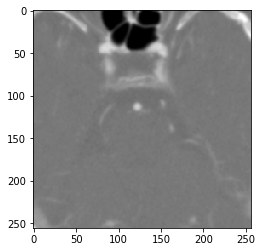

In [157]:
plt.imshow(crop(contrast_total_images[0][0]), cmap='gray')

In [158]:
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans

### 2. Binarization

In [253]:
# binarization
def binarization(image, manufacturer='GE'):
    if manufacturer == 'GE':
        bin_pixel1 = image > 1110
        bin_pixel2 = image < 1500
        bin_pixel = bin_pixel1 & bin_pixel2
        # bin_pixel = bin_pixel 
    else:
        bin
    
    return np.where(image, bin_pixel, 0)

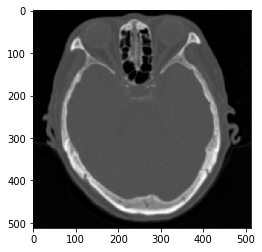

In [268]:
plt.imshow(original_total_images[0][0], cmap='gray')

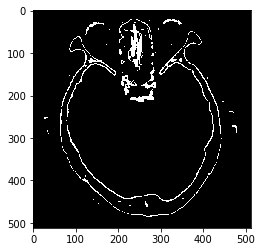

In [269]:
plt.imshow(binarization(original_total_images[0][0]), cmap='gray')

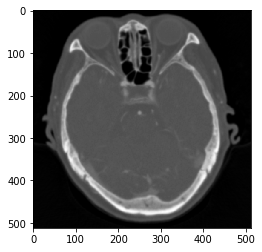

In [255]:
plt.imshow(contrast_total_images[0][0], cmap='gray')

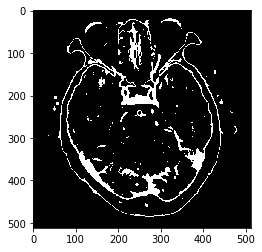

In [270]:
#plt.figure(figsize=(15,15))
plt.imshow(binarization(contrast_total_images[0][0]), cmap='gray')

### SIEMENS

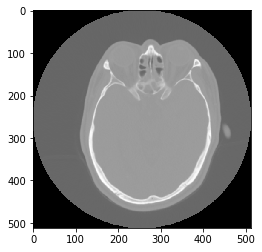

In [273]:
#plt.figure(figsize=(15,15))
plt.imshow(original_total_images[54][3], cmap='gray')

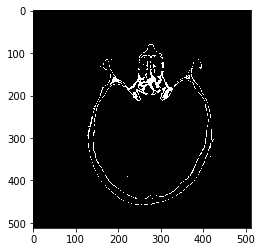

In [280]:
#plt.figure(figsize=(15,15))
plt.imshow(binarization(original_total_images[54][3]), cmap='gray')

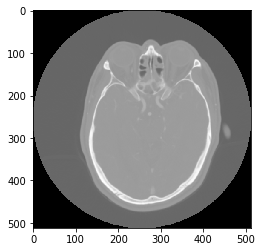

In [279]:
#plt.figure(figsize=(15,15))
plt.imshow(contrast_total_images[54][3], cmap='gray')

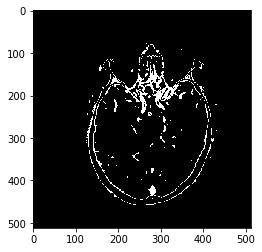

In [281]:
#plt.figure(figsize=(15,15))
plt.imshow(binarization(contrast_total_images[54][3]), cmap='gray')

### 3. 